In [4]:
import numpy as np
import pandas as pd

In [24]:
df = pd.read_csv('../data/results.csv')
fr = pd.read_csv('../data/fifa_ranking.csv')
st = pd.read_csv('../data/shootouts.csv')

In [20]:
# some countries have different names between results dataset and fifa raning dataset
country_sys = {
    'Cape Verde' : 'Cabo Verde',
    'DR Congo' : 'Congo DR',
    'Kyrgyzstan' : 'Kyrgyz Republic',
    'Ivory Coast' : "Côte d'Ivoire",
    'Iran' : 'IR Iran',
    'United States' : 'USA',
    'Turkey' : 'Türkiye',
    'South Korea' : 'Korea Republic',
    'Saint Vincent and the Grenadines' : 'St. Vincent and the Grenadines',
    'Saint Lucia' : 'St. Lucia',
    'United States Virgin Islands':'US Virgin Islands',
    'Brunei' : 'Brunei Darussalam',
    'North Korea' : 'Korea DPR',
    'Saint Kitts and Nevis' : 'St. Kitts and Nevis'
}

In [21]:
df['home_team'] = df['home_team'].replace(country_sys)
df['away_team'] = df['away_team'].replace(country_sys)

In [22]:
# we are only interested in official tournaments
tournaments = ['Copa América', 'FIFA World Cup', 'FIFA World Cup qualification', 'International Cup'
              , 'AFC Asian Cup qualification', 'AFC Asian Cup', 'African Cup of Nations'
              , 'UEFA Euro qualification', 'UEFA Euro', 'African Cup of Nations qualification'
              , 'CONCACAF Championship', 'CONCACAF Championship qualification' 
              , 'CONMEBOL–UEFA Cup of Champions', 'Confederations Cup'
              , 'Oceania Nations Cup qualification','Copa América qualification'
              , 'UEFA Nations League', 'CONCACAF Nations League qualification'
              , 'CONCACAF Nations League','AFF Championship qualification']

In [48]:
# to remove home team advantage we will duplicate the dataset with both teams home and away
# this will allow us to remove the hoe advantage

df_dup = df.copy()

df_dup['home_team'] = df['away_team']
df_dup['away_team'] = df['home_team']
df_dup['home_score'] = df['away_score']
df_dup['away_score'] = df['home_score']

In [49]:
# concatenate both of them
dt = pd.concat([df, df_dup])

In [54]:
# year and month to do concatenate for rankings
dt['year'] = dt.apply(lambda x: int(x.date[:4]), axis=1)
dt['month'] = dt.apply(lambda x: int(x.date[5:7]), axis=1)

fr['year'] = fr.apply(lambda x: int(x.rank_date[:4]), axis=1)
fr['month'] = fr.apply(lambda x: int(x.rank_date[5:7]), axis=1)

In [57]:
# merging the data
data = dt.merge(fr, left_on=['home_team', 'year', 'month'], 
                right_on=['country_full', 'year', 'month'], 
               suffixes=('', '__home'))

data = data.merge(fr, left_on=['away_team', 'year', 'month'], 
                right_on=['country_full', 'year', 'month'], 
               suffixes=('', '__away'))

In [60]:
# League Of Legends?

data['home_tier'] = ''
data.loc[data['rank'] > 32, 'home_tier'] = 'bronze'
data.loc[data['rank'] <= 32, 'home_tier'] = 'silver'
data.loc[data['rank'] <= 16, 'home_tier'] = 'gold'
data.loc[data['rank'] <= 8, 'home_tier'] = 'diamond'

data['away_tier'] = ''
data.loc[data['rank__away'] > 32, 'away_tier'] = 'bronze'
data.loc[data['rank__away'] <= 32, 'away_tier'] = 'silver'
data.loc[data['rank__away'] <= 16, 'away_tier'] = 'gold'
data.loc[data['rank__away'] <= 8, 'away_tier'] = 'diamond'

In [62]:
def winner(home_score, away_score):
    if home_score > away_score:
        return 'home_win'
    elif home_score < away_score:
        return 'home_lose'        
    else:
        return 'draw'

In [63]:
data['winner'] = data.apply(lambda x: winner(x.home_score, x.away_score), axis=1)

In [77]:
# we need to know by how much a team is supperior to another
# to do that we can use the ranking points and see how much a team is advantageous to another one

fr_standard = fr.groupby(['year', 'month']).agg(
    mean_total_points = ('total_points', 'mean'),
    std_total_points = ('total_points', 'std')
).reset_index()

In [78]:
# merge

data = data.merge(fr_standard, left_on=['year', 'month'], 
                right_on=['year', 'month'], 
               suffixes=('', '__ranking_standard'))

In [82]:
# how (relatively) a team is stronger than the other
data['marginal_effect'] = (data['total_points'] - data['total_points__away']) / data['total_points__away']

In [151]:
# absolute team strength (compared to all teams)
data['absolute_effect__home'] = (data['total_points'] - data['mean_total_points'])/data['std_total_points']
data['absolute_effect__away'] = (data['total_points__away'] - data['mean_total_points'])/data['std_total_points']

In [154]:
# how (relatively) a team is stronger than the other
data['absolute_effect'] = (data['total_points'] - data['total_points__away']) / data['std_total_points']

In [271]:
# Let's only take official tournaments
data = data.loc[data.tournament.isin(tournaments), ]

In [287]:
# let's split the data into training / test and have at least 1 world cup to judge the algo

date_train = '2018-06-14'

data_train = data.loc[data.date < date_train, ]
data_test = data.loc[data.date >= date_train, ]

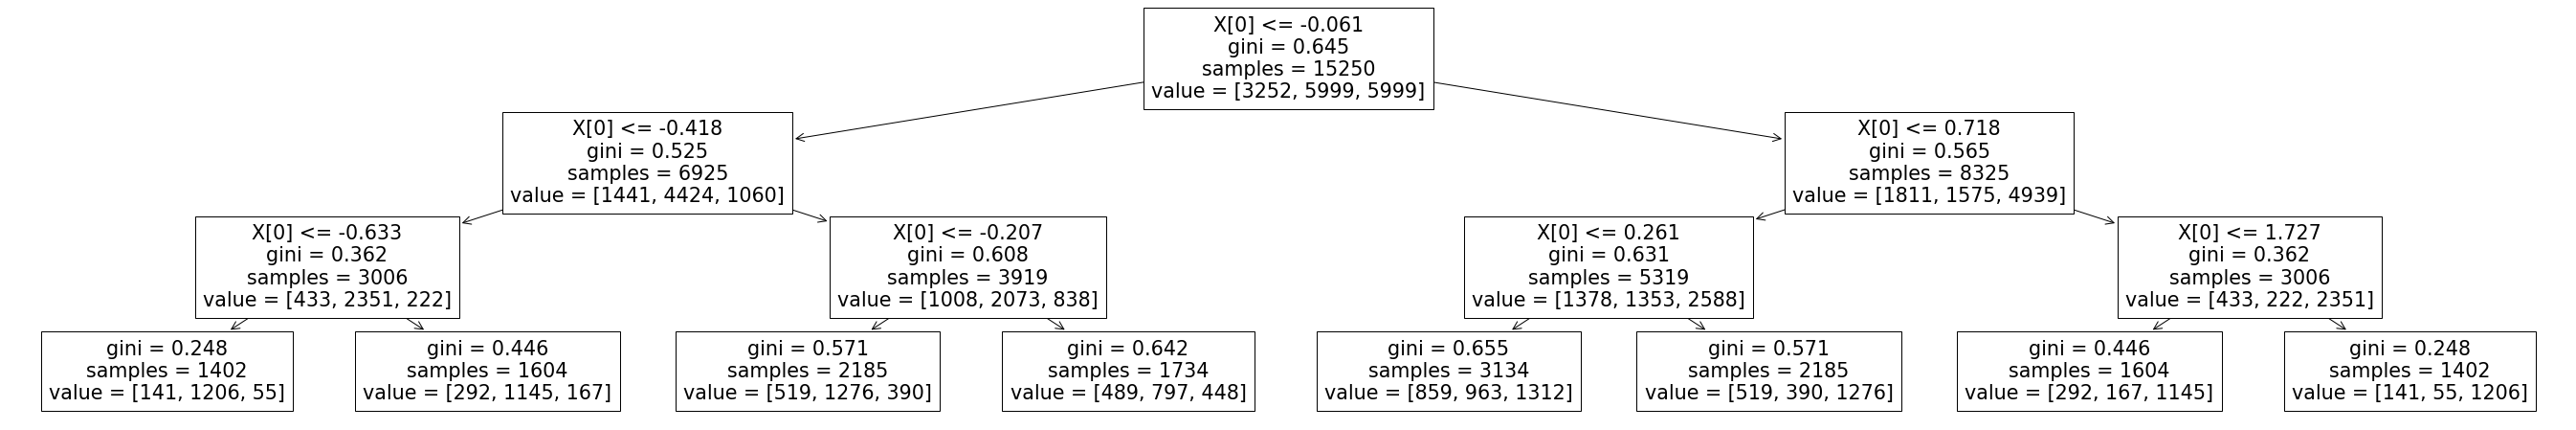

In [290]:
# let's determine marginal_effect cutoffs
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

x_ = np.array(data_train['marginal_effect']).reshape(-1, 1)
y_ = data_train.winner

clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_, y_)


plt.figure(figsize=(48, 8))
plot_tree(clf)
plt.show()

In [295]:
# thresholds should be set from training data only
for d in [data_train, data_test]:
    d['marginal_effect_tier'] = ''
    d.loc[d.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
    d.loc[d.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
    d.loc[d.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
    d.loc[d.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
    d.loc[d.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
    d.loc[d.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
    d.loc[d.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
    d.loc[d.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

<ipython-input-295-fd7149833cdc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['effect_tier'] = ''


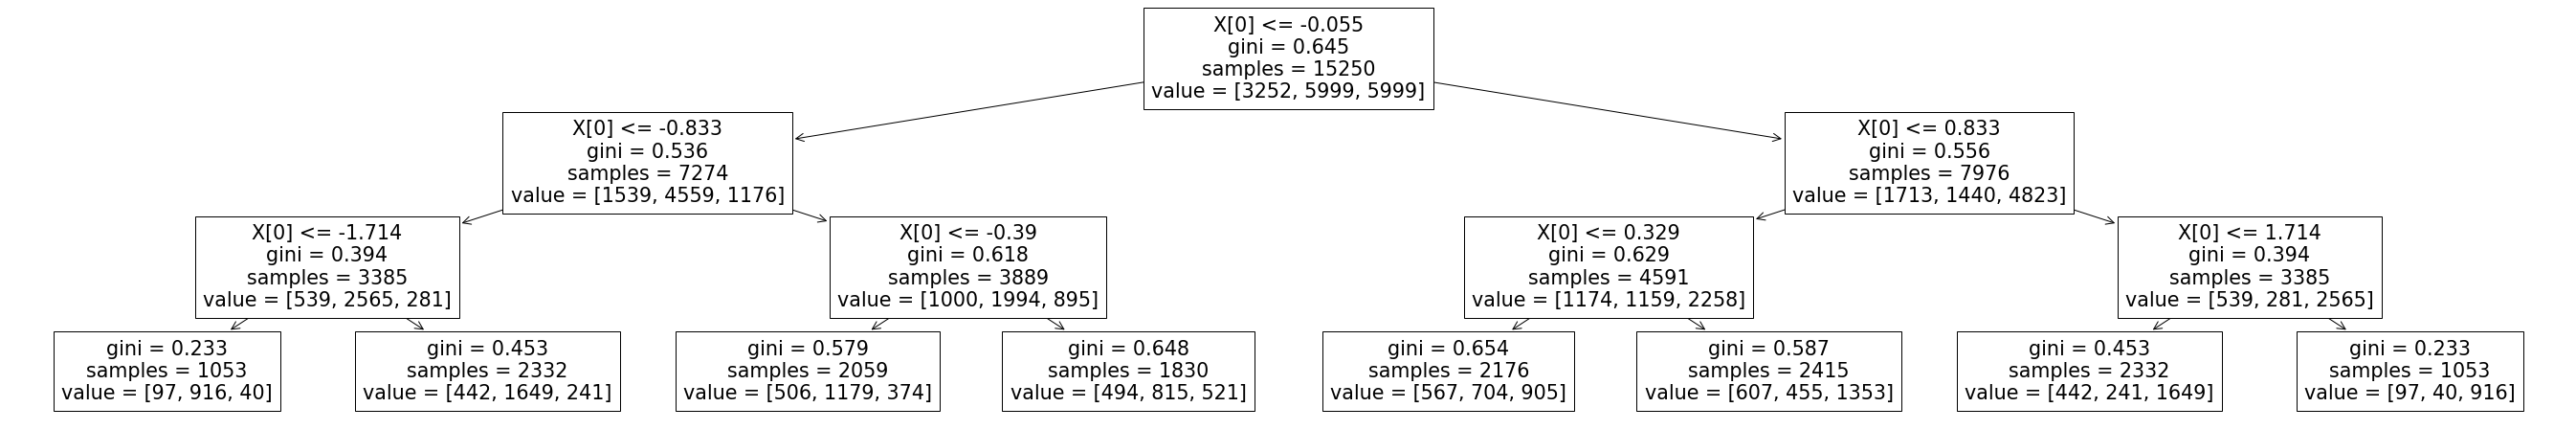

In [302]:
# let's determine marginal_effect cutoffs
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

x_ = np.array(data_train['absolute_effect']).reshape(-1, 1)
y_ = data_train.winner

clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_, y_)


plt.figure(figsize=(48, 8))
plot_tree(clf)
plt.show()

In [303]:
# thresholds should be set from training data only
for d in [data_train, data_test]:
    d['absolute_effect_tier'] = ''
    d.loc[d.absolute_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
    d.loc[d.absolute_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
    d.loc[d.absolute_effect > -.833, 'absolute_effect_tier'] = 'low'
    d.loc[d.absolute_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
    d.loc[d.absolute_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
    d.loc[d.absolute_effect > .329, 'absolute_effect_tier'] = 'high'
    d.loc[d.absolute_effect > .833, 'absolute_effect_tier'] = 'very_high'
    d.loc[d.absolute_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

<ipython-input-303-d2d0068937db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['effect_tier'] = ''
<ipython-input-303-d2d0068937db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[d.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
<ipython-input-303-d2d0068937db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [308]:
### Maybe Later ###

#data['date_'] = pd.to_datetime(data['date'])
#data['date__'] = data.apply(lambda x: x['date_'].to_pydatetime(), axis=1)
#data['date__year'] = data.date__.dt.year
#data['date__month'] = data.date__.dt.month
#data['date__day'] = data.date__.dt.day
#data.loc[data.home_team=="Morocco", ].date__

#(data.iloc[123]['date_'].to_pydatetime() - data.iloc[0]['date_'].to_pydatetime()).days
#data.loc[data.home_team=="Morocco", ].rolling(2).apply(lambda x: x.iloc[0] - x.iloc[1])
#data.loc[data.home_team=="Morocco", ].date__year.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])
#data.loc[data.home_team=="Morocco", ].date__month.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])
#data.loc[data.home_team=="Morocco", ].date__day.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])
#data.loc[data.home_team=="Morocco", 'date_previous'] = data.loc[data.home_team=="Morocco", ].date__.shift(5)

#data['avg_score__home'] = data.apply(lambda x:)

#data.loc[data.home_team=="Morocco", 'date_diff'] = (data.loc[data.home_team=="Morocco", 'date__'] - data.loc[data.home_team=="Morocco", 'date_previous']).dt.days

In [310]:
predictors_ = ['home_team',
 'away_team',
 'confederation',
 'confederation__away',
 'home_tier',
 'away_tier',
 'marginal_effect_tier',
 'absolute_effect_tier']

X_train = pd.get_dummies(data_train[predictors_])
y_train = data_train['winner'].replace({'draw':0, 'home_lose':1, 'home_win':2})

In [347]:
X_test = pd.get_dummies(data_test[predictors_])
y_test = data_test['winner'].replace({'draw':0, 'home_lose':1, 'home_win':2})

In [311]:
import logging

log_fmt = '%(asctime)s - %(name)s - %(funcName)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)

In [315]:
import xgboost as xgb

xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)

In [332]:
from sklearn.model_selection import KFold

folds = KFold(n_splits=3)

#best_max_depth = -1
#best_num_trees = 0
min_test = 100000

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    logger.info('max_depth={}'.format(k))
    xgb_param = xgb.XGBClassifier(max_depth=k).get_xgb_params()

    xgb_param['objective'] = 'multi:softprob'
    xgb_param['num_class'] = 3
    #'reg:squarederror' num_trees 4 / max_depth 6 ||| train 21.0 Test 15.4

    cvresult = xgb.cv(
        xgb_param, xgtrain, num_boost_round=1000, 
        metrics='mlogloss',
        folds=folds,
        early_stopping_rounds=20, verbose_eval=0
    )

    logger.info('trees : {0}'.format(cvresult.index.max()))
    logger.info('train {0:.1f} Test {1:.1f}'.format(cvresult.iloc[cvresult.index.max()][0], cvresult.iloc[cvresult.index.max()][2]))

    if cvresult.iloc[cvresult.index.max()][2] < min_test:
        logger.info('better : {0} < {1} (best_ax_depth {2}=>{3})'.format(cvresult.iloc[cvresult.index.max()][2], min_test, best_max_depth, k))
        min_test = cvresult.iloc[cvresult.index.max()][2]
        best_max_depth = k
        best_num_trees = cvresult.index.max()
    #cvresult
    #plt.figure(figsize=(12, 8))
    #cvresult['num_trees'] = cvresult.index
    #ax = sns.lineplot(x='num_trees', y='train-mae-mean', data=cvresult)
    #ax = sns.lineplot(x='num_trees', y='test-mae-mean', data=cvresult)
    #plt.show()
    
logger.info('-'*50)
logger.info('best_max_depth {0}'.format(best_max_depth))
logger.info('best_num_trees {0}'.format(best_num_trees))

2022-11-14 09:45:28,656 - __main__ - <module> - INFO - max_depth=2


[0]	train-mlogloss:1.03333+0.00067	test-mlogloss:1.03398+0.00378
[1]	train-mlogloss:0.98903+0.00118	test-mlogloss:0.99133+0.00351
[2]	train-mlogloss:0.96068+0.00265	test-mlogloss:0.96424+0.00313
[3]	train-mlogloss:0.93969+0.00238	test-mlogloss:0.94251+0.00373
[4]	train-mlogloss:0.92557+0.00237	test-mlogloss:0.92935+0.00371
[5]	train-mlogloss:0.91434+0.00248	test-mlogloss:0.91875+0.00259
[6]	train-mlogloss:0.90550+0.00259	test-mlogloss:0.91073+0.00226
[7]	train-mlogloss:0.89864+0.00243	test-mlogloss:0.90407+0.00214
[8]	train-mlogloss:0.89275+0.00280	test-mlogloss:0.89857+0.00227
[9]	train-mlogloss:0.88798+0.00276	test-mlogloss:0.89420+0.00246
[10]	train-mlogloss:0.88431+0.00282	test-mlogloss:0.89126+0.00291
[11]	train-mlogloss:0.88127+0.00290	test-mlogloss:0.88846+0.00320
[12]	train-mlogloss:0.87854+0.00288	test-mlogloss:0.88588+0.00358
[13]	train-mlogloss:0.87629+0.00277	test-mlogloss:0.88374+0.00391
[14]	train-mlogloss:0.87449+0.00280	test-mlogloss:0.88232+0.00399
[15]	train-mlogloss:

2022-11-14 09:45:55,862 - __main__ - <module> - INFO - trees : 51
2022-11-14 09:45:55,865 - __main__ - <module> - INFO - train 0.9 Test 0.9
2022-11-14 09:45:55,867 - __main__ - <module> - INFO - better : 0.8740770000000001 < 100000 (best_ax_depth -1=>2)
2022-11-14 09:45:55,869 - __main__ - <module> - INFO - max_depth=3


[0]	train-mlogloss:1.01489+0.00088	test-mlogloss:1.01599+0.00430
[1]	train-mlogloss:0.96419+0.00211	test-mlogloss:0.96622+0.00412
[2]	train-mlogloss:0.93327+0.00266	test-mlogloss:0.93762+0.00525
[3]	train-mlogloss:0.91322+0.00283	test-mlogloss:0.91852+0.00483
[4]	train-mlogloss:0.89874+0.00259	test-mlogloss:0.90521+0.00367
[5]	train-mlogloss:0.88905+0.00243	test-mlogloss:0.89575+0.00334
[6]	train-mlogloss:0.88187+0.00276	test-mlogloss:0.88997+0.00308
[7]	train-mlogloss:0.87647+0.00292	test-mlogloss:0.88574+0.00238
[8]	train-mlogloss:0.87243+0.00289	test-mlogloss:0.88254+0.00264
[9]	train-mlogloss:0.86943+0.00282	test-mlogloss:0.88003+0.00278
[10]	train-mlogloss:0.86680+0.00287	test-mlogloss:0.87830+0.00353
[11]	train-mlogloss:0.86481+0.00280	test-mlogloss:0.87700+0.00383
[12]	train-mlogloss:0.86317+0.00286	test-mlogloss:0.87628+0.00422
[13]	train-mlogloss:0.86182+0.00274	test-mlogloss:0.87579+0.00447
[14]	train-mlogloss:0.86055+0.00275	test-mlogloss:0.87525+0.00453
[15]	train-mlogloss:

2022-11-14 09:46:26,644 - __main__ - <module> - INFO - trees : 30
2022-11-14 09:46:26,648 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:46:26,651 - __main__ - <module> - INFO - better : 0.8729726666666666 < 0.8740770000000001 (best_ax_depth 2=>3)
2022-11-14 09:46:26,654 - __main__ - <module> - INFO - max_depth=4


[0]	train-mlogloss:1.00528+0.00147	test-mlogloss:1.00774+0.00470
[1]	train-mlogloss:0.95199+0.00237	test-mlogloss:0.95685+0.00541
[2]	train-mlogloss:0.91966+0.00302	test-mlogloss:0.92686+0.00556
[3]	train-mlogloss:0.89920+0.00322	test-mlogloss:0.90912+0.00539
[4]	train-mlogloss:0.88547+0.00308	test-mlogloss:0.89709+0.00372
[5]	train-mlogloss:0.87637+0.00296	test-mlogloss:0.88964+0.00331
[6]	train-mlogloss:0.86974+0.00311	test-mlogloss:0.88467+0.00277
[7]	train-mlogloss:0.86485+0.00303	test-mlogloss:0.88130+0.00251
[8]	train-mlogloss:0.86118+0.00287	test-mlogloss:0.87892+0.00291
[9]	train-mlogloss:0.85841+0.00269	test-mlogloss:0.87724+0.00288
[10]	train-mlogloss:0.85586+0.00268	test-mlogloss:0.87624+0.00344
[11]	train-mlogloss:0.85391+0.00289	test-mlogloss:0.87567+0.00380
[12]	train-mlogloss:0.85200+0.00271	test-mlogloss:0.87491+0.00429
[13]	train-mlogloss:0.85054+0.00273	test-mlogloss:0.87456+0.00437
[14]	train-mlogloss:0.84909+0.00252	test-mlogloss:0.87438+0.00457
[15]	train-mlogloss:

2022-11-14 09:47:02,581 - __main__ - <module> - INFO - trees : 21
2022-11-14 09:47:02,589 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:47:02,591 - __main__ - <module> - INFO - max_depth=5


[0]	train-mlogloss:1.00196+0.00128	test-mlogloss:1.00565+0.00568
[1]	train-mlogloss:0.94639+0.00189	test-mlogloss:0.95389+0.00646
[2]	train-mlogloss:0.91228+0.00245	test-mlogloss:0.92291+0.00594
[3]	train-mlogloss:0.89071+0.00283	test-mlogloss:0.90453+0.00494
[4]	train-mlogloss:0.87665+0.00300	test-mlogloss:0.89313+0.00379
[5]	train-mlogloss:0.86718+0.00307	test-mlogloss:0.88636+0.00320
[6]	train-mlogloss:0.86044+0.00324	test-mlogloss:0.88196+0.00251
[7]	train-mlogloss:0.85537+0.00337	test-mlogloss:0.87948+0.00246
[8]	train-mlogloss:0.85156+0.00334	test-mlogloss:0.87759+0.00280
[9]	train-mlogloss:0.84852+0.00331	test-mlogloss:0.87663+0.00321
[10]	train-mlogloss:0.84637+0.00328	test-mlogloss:0.87591+0.00333
[11]	train-mlogloss:0.84413+0.00342	test-mlogloss:0.87545+0.00391
[12]	train-mlogloss:0.84237+0.00333	test-mlogloss:0.87515+0.00392
[13]	train-mlogloss:0.84031+0.00305	test-mlogloss:0.87494+0.00405
[14]	train-mlogloss:0.83888+0.00312	test-mlogloss:0.87456+0.00422
[15]	train-mlogloss:

2022-11-14 09:47:37,626 - __main__ - <module> - INFO - trees : 17
2022-11-14 09:47:37,626 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:47:37,626 - __main__ - <module> - INFO - max_depth=6


[0]	train-mlogloss:0.99960+0.00134	test-mlogloss:1.00514+0.00535
[1]	train-mlogloss:0.94238+0.00217	test-mlogloss:0.95289+0.00640
[2]	train-mlogloss:0.90680+0.00279	test-mlogloss:0.92257+0.00588
[3]	train-mlogloss:0.88409+0.00322	test-mlogloss:0.90403+0.00481
[4]	train-mlogloss:0.86913+0.00351	test-mlogloss:0.89293+0.00375
[5]	train-mlogloss:0.85879+0.00354	test-mlogloss:0.88614+0.00307
[6]	train-mlogloss:0.85148+0.00358	test-mlogloss:0.88208+0.00302
[7]	train-mlogloss:0.84574+0.00360	test-mlogloss:0.87942+0.00302
[8]	train-mlogloss:0.84168+0.00366	test-mlogloss:0.87791+0.00338
[9]	train-mlogloss:0.83822+0.00341	test-mlogloss:0.87707+0.00370
[10]	train-mlogloss:0.83503+0.00312	test-mlogloss:0.87644+0.00444
[11]	train-mlogloss:0.83281+0.00300	test-mlogloss:0.87610+0.00439
[12]	train-mlogloss:0.83070+0.00274	test-mlogloss:0.87596+0.00457
[13]	train-mlogloss:0.82876+0.00246	test-mlogloss:0.87589+0.00499
[14]	train-mlogloss:0.82705+0.00249	test-mlogloss:0.87573+0.00512
[15]	train-mlogloss:

2022-11-14 09:48:33,812 - __main__ - <module> - INFO - trees : 15
2022-11-14 09:48:33,821 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:48:33,825 - __main__ - <module> - INFO - max_depth=7


[0]	train-mlogloss:0.99735+0.00145	test-mlogloss:1.00506+0.00502
[1]	train-mlogloss:0.93851+0.00251	test-mlogloss:0.95295+0.00603
[2]	train-mlogloss:0.90154+0.00301	test-mlogloss:0.92254+0.00578
[3]	train-mlogloss:0.87777+0.00351	test-mlogloss:0.90449+0.00473
[4]	train-mlogloss:0.86178+0.00403	test-mlogloss:0.89358+0.00342
[5]	train-mlogloss:0.85068+0.00419	test-mlogloss:0.88705+0.00303
[6]	train-mlogloss:0.84290+0.00431	test-mlogloss:0.88329+0.00285
[7]	train-mlogloss:0.83665+0.00474	test-mlogloss:0.88073+0.00304
[8]	train-mlogloss:0.83162+0.00466	test-mlogloss:0.87931+0.00362
[9]	train-mlogloss:0.82788+0.00453	test-mlogloss:0.87867+0.00409
[10]	train-mlogloss:0.82461+0.00459	test-mlogloss:0.87837+0.00441
[11]	train-mlogloss:0.82186+0.00422	test-mlogloss:0.87855+0.00451
[12]	train-mlogloss:0.81900+0.00418	test-mlogloss:0.87806+0.00486
[13]	train-mlogloss:0.81702+0.00421	test-mlogloss:0.87790+0.00486
[14]	train-mlogloss:0.81531+0.00422	test-mlogloss:0.87790+0.00498
[15]	train-mlogloss:

2022-11-14 09:49:26,418 - __main__ - <module> - INFO - trees : 15
2022-11-14 09:49:26,422 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:49:26,423 - __main__ - <module> - INFO - max_depth=8


[0]	train-mlogloss:0.99520+0.00164	test-mlogloss:1.00501+0.00456
[1]	train-mlogloss:0.93469+0.00276	test-mlogloss:0.95310+0.00571
[2]	train-mlogloss:0.89651+0.00341	test-mlogloss:0.92291+0.00503
[3]	train-mlogloss:0.87163+0.00364	test-mlogloss:0.90463+0.00394
[4]	train-mlogloss:0.85432+0.00425	test-mlogloss:0.89392+0.00306
[5]	train-mlogloss:0.84252+0.00469	test-mlogloss:0.88774+0.00250
[6]	train-mlogloss:0.83417+0.00447	test-mlogloss:0.88382+0.00258
[7]	train-mlogloss:0.82754+0.00504	test-mlogloss:0.88142+0.00296
[8]	train-mlogloss:0.82227+0.00493	test-mlogloss:0.88001+0.00383
[9]	train-mlogloss:0.81817+0.00472	test-mlogloss:0.87930+0.00426
[10]	train-mlogloss:0.81401+0.00448	test-mlogloss:0.87903+0.00506
[11]	train-mlogloss:0.81120+0.00405	test-mlogloss:0.87865+0.00521
[12]	train-mlogloss:0.80859+0.00384	test-mlogloss:0.87843+0.00536
[13]	train-mlogloss:0.80637+0.00425	test-mlogloss:0.87847+0.00562
[14]	train-mlogloss:0.80418+0.00385	test-mlogloss:0.87866+0.00564
[15]	train-mlogloss:

2022-11-14 09:50:18,667 - __main__ - <module> - INFO - trees : 12
2022-11-14 09:50:18,670 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:50:18,672 - __main__ - <module> - INFO - max_depth=9


[0]	train-mlogloss:0.99329+0.00190	test-mlogloss:1.00514+0.00420
[1]	train-mlogloss:0.93105+0.00324	test-mlogloss:0.95340+0.00537
[2]	train-mlogloss:0.89161+0.00382	test-mlogloss:0.92341+0.00479
[3]	train-mlogloss:0.86575+0.00420	test-mlogloss:0.90520+0.00395
[4]	train-mlogloss:0.84771+0.00480	test-mlogloss:0.89492+0.00314
[5]	train-mlogloss:0.83506+0.00502	test-mlogloss:0.88859+0.00289
[6]	train-mlogloss:0.82588+0.00523	test-mlogloss:0.88484+0.00329
[7]	train-mlogloss:0.81889+0.00582	test-mlogloss:0.88274+0.00371
[8]	train-mlogloss:0.81281+0.00532	test-mlogloss:0.88119+0.00460
[9]	train-mlogloss:0.80866+0.00520	test-mlogloss:0.88031+0.00506
[10]	train-mlogloss:0.80416+0.00546	test-mlogloss:0.88046+0.00535
[11]	train-mlogloss:0.80072+0.00522	test-mlogloss:0.88050+0.00541
[12]	train-mlogloss:0.79803+0.00473	test-mlogloss:0.88038+0.00563
[13]	train-mlogloss:0.79575+0.00473	test-mlogloss:0.88079+0.00555
[14]	train-mlogloss:0.79342+0.00468	test-mlogloss:0.88116+0.00559
[15]	train-mlogloss:

2022-11-14 09:51:09,112 - __main__ - <module> - INFO - trees : 9
2022-11-14 09:51:09,112 - __main__ - <module> - INFO - train 0.8 Test 0.9
2022-11-14 09:51:09,121 - __main__ - <module> - INFO - max_depth=10


[0]	train-mlogloss:0.99142+0.00206	test-mlogloss:1.00533+0.00398
[1]	train-mlogloss:0.92790+0.00330	test-mlogloss:0.95407+0.00531
[2]	train-mlogloss:0.88729+0.00381	test-mlogloss:0.92421+0.00501
[3]	train-mlogloss:0.86005+0.00429	test-mlogloss:0.90675+0.00403
[4]	train-mlogloss:0.84119+0.00461	test-mlogloss:0.89646+0.00318
[5]	train-mlogloss:0.82783+0.00490	test-mlogloss:0.89037+0.00333
[6]	train-mlogloss:0.81757+0.00492	test-mlogloss:0.88686+0.00370
[7]	train-mlogloss:0.81016+0.00521	test-mlogloss:0.88486+0.00414
[8]	train-mlogloss:0.80454+0.00496	test-mlogloss:0.88368+0.00477
[9]	train-mlogloss:0.79881+0.00486	test-mlogloss:0.88314+0.00566
[10]	train-mlogloss:0.79502+0.00491	test-mlogloss:0.88307+0.00579
[11]	train-mlogloss:0.79126+0.00474	test-mlogloss:0.88309+0.00591
[12]	train-mlogloss:0.78808+0.00423	test-mlogloss:0.88303+0.00612
[13]	train-mlogloss:0.78588+0.00396	test-mlogloss:0.88345+0.00636
[14]	train-mlogloss:0.78313+0.00375	test-mlogloss:0.88392+0.00645
[15]	train-mlogloss:

2022-11-14 09:52:33,856 - __main__ - <module> - INFO - trees : 12
2022-11-14 09:52:33,862 - __main__ - <module> - INFO - train 0.8 Test 0.9


In [344]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

tscv = KFold(n_splits=3)

xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
min_test = 100000

#best_max_depth
#best_num_trees

logger.info('max_depth : {0} num_trees : {1}'.format(best_max_depth, best_num_trees))
#cols = list(X_train.columns[selector.support_])
cols = X_train.columns

reg = xgb.XGBClassifier()
grid_params = {
    'objective': ['multi:softprob'],
    'n_estimators' : [best_num_trees],
    'max_depth' : [best_max_depth],
    'min_child_weight' : [2],
    #'colsample_bylevel': [i/10. for i in range(1,11)], #[.9], #
    #'colsample_bynode': [i/10. for i in range(1,11)], #[.9], 
    'colsample_bytree': [i/10. for i in range(1,11)], #[1.], #
    'subsample': [i/10. for i in range(1,11)], #[1.], #
    'learning_rate' : [.3], #[.3, .2, .1, .05, .01, .005]
}
#{'max_depth': 3, 'n_estimators': 30}

gs = GridSearchCV(estimator=reg,
                param_grid=grid_params,
                scoring='f1_weighted',
                n_jobs=-1, verbose=4,
                cv=tscv,
                return_train_score=True)

gs = gs.fit(X_train, y_train)
logger.info('best score : {0}'.format(gs.best_score_))
logger.info('best params : {0}'.format(gs.best_params_))

#logger.info('training on project {0} ...'.format(id_project))
model = gs.best_estimator_

2022-11-14 12:12:03,973 - __main__ - <module> - INFO - max_depth : 3 num_trees : 30


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2022-11-14 12:35:47,274 - __main__ - <module> - INFO - best score : 0.5483548906937222
2022-11-14 12:35:47,284 - __main__ - <module> - INFO - best params : {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 30, 'objective': 'multi:softprob', 'subsample': 0.1}


In [352]:
for col in cols:
    if col not in X_test.columns:
        X_test[col] = 0

In [353]:
from sklearn.metrics import classification_report

print('-'*20 + 'TRAIN' + '-'*20)
print(classification_report(y_train, model.predict(X_train)))
print('-'*20 + 'TEST' + '-'*20)
print(classification_report(y_test, model.predict(X_test[cols])))

--------------------TRAIN--------------------
              precision    recall  f1-score   support

           0       0.37      0.03      0.05      3252
           1       0.64      0.75      0.69      5999
           2       0.60      0.80      0.69      5999

    accuracy                           0.62     15250
   macro avg       0.54      0.53      0.48     15250
weighted avg       0.57      0.62      0.55     15250

--------------------TEST--------------------
              precision    recall  f1-score   support

           0       0.39      0.06      0.11       722
           1       0.67      0.68      0.68      1233
           2       0.57      0.84      0.68      1233

    accuracy                           0.60      3188
   macro avg       0.55      0.53      0.49      3188
weighted avg       0.57      0.60      0.55      3188



In [905]:
# thresholds should be set from training data only
for d in [data]:
    d['marginal_effect_tier'] = ''
    d.loc[d.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
    d.loc[d.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
    d.loc[d.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
    d.loc[d.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
    d.loc[d.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
    d.loc[d.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
    d.loc[d.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
    d.loc[d.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

# thresholds should be set from training data only
for d in [data]:
    d['absolute_effect_tier'] = ''
    d.loc[d.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
    d.loc[d.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
    d.loc[d.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
    d.loc[d.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
    d.loc[d.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
    d.loc[d.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
    d.loc[d.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
    d.loc[d.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

In [914]:
params = {
    'max_depth': 3,
    'n_estimators': 30,
    'colsample_bytree': 0.8, 
    'learning_rate': 0.3, 
    'min_child_weight': 2, 
    'objective': 'multi:softprob', 
    'subsample': 0.1
}

X = pd.get_dummies(data[predictors_])
y = data['winner'].replace({'draw':0, 'home_lose':1, 'home_win':2})

#xgb_model = xgb.XGBClassifier(params=**params)
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=30, colsample_bytree=.8, min_child_weight=2, subsample=.1)
xgb_model.fit(X, y)

print('-'*20 + 'TRAIN' + '-'*20)
print(classification_report(y, xgb_model.predict(X)))

--------------------TRAIN--------------------
              precision    recall  f1-score   support

           0       0.34      0.02      0.03      3974
           1       0.64      0.74      0.68      7232
           2       0.59      0.82      0.69      7232

    accuracy                           0.61     18438
   macro avg       0.53      0.52      0.47     18438
weighted avg       0.56      0.61      0.55     18438



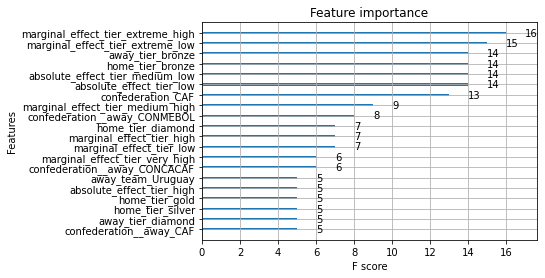

In [915]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=20, importance_type='weight')
plt.show()

In [928]:
#data['winner_prediction_'] = xgb_model.predict(X)
data[['prediction_draw', 'prediction_home_lose', 'prediction_home_win']] = xgb_model.predict_proba(X)
#data['winner_prediction'] = data['winner_prediction_'].replace({0:'draw', 1:'home_lose', 2:'home_win'})

In [932]:
data.to_csv('../data/prediction_xgb_model.csv', sep=';', decimal=',')

In [933]:
data.query('marginal_effect_tier=="extreme_low" and winner=="home_lose" and winner_prediction=="home_win"').sort_values(by='date', ascending=False)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,rank__away,country_full__away,country_abrv__away,total_points__away,previous_points__away,rank_change__away,confederation__away,rank_date__away,home_tier,away_tier,winner,mean_total_points,std_total_points,marginal_effect,absolute_effect__home,absolute_effect__away,absolute_effect,date_,date__,date__month,date__year,date__day,date_previous,date_diff,effect_tier,marginal_effect_tier,absolute_effect_tier,winner_prediction,winner_prediction_,prediction_draw,prediction_home_lose,prediction_home_win


In [940]:
data.query('winner=="home_win" and winner_prediction=="home_lose"').sort_values(by=['marginal_effect', 'prediction_home_lose'], ascending=[False, False])

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,rank__away,country_full__away,country_abrv__away,total_points__away,previous_points__away,rank_change__away,confederation__away,rank_date__away,home_tier,away_tier,winner,mean_total_points,std_total_points,marginal_effect,absolute_effect__home,absolute_effect__away,absolute_effect,date_,date__,date__month,date__year,date__day,date_previous,date_diff,effect_tier,marginal_effect_tier,absolute_effect_tier,winner_prediction,winner_prediction_,prediction_draw,prediction_home_lose,prediction_home_win
6237,1999-11-13,England,Scotland,2.0,0.0,UEFA Euro qualification,Glasgow,Scotland,False,1999,11,11,England,ENG,703.0,688.0,-1,UEFA,1999-11-17,23,Scotland,SCO,617.0,630.0,3,UEFA,1999-11-17,gold,silver,home_win,356.741294,211.648111,0.139384,1.636011,1.229676,0.406335,1999-11-13,1999-11-13,11,1999,13,NaT,NaN,,medium_high,medium_high,home_lose,1,0.229151,0.397487,0.373362
3581,1997-06-18,Bolivia,Uruguay,1.0,0.0,Copa América,La Paz,Bolivia,False,1997,6,34,Bolivia,BOL,50.0,49.0,2,CONMEBOL,1997-06-18,51,Uruguay,URU,44.0,43.0,-3,CONMEBOL,1997-06-18,bronze,bronze,home_win,30.481081,18.023262,0.136364,1.082985,0.750082,0.332903,1997-06-18,1997-06-18,6,1997,18,NaT,NaN,,medium_high,medium_high,home_lose,1,0.230515,0.395549,0.373936
13228,2004-07-13,Argentina,Uruguay,4.0,2.0,Copa América,Piura,Peru,True,2004,7,11,Argentina,ARG,722.0,733.0,6,CONMEBOL,2004-07-07,32,Uruguay,URU,638.0,649.0,3,CONMEBOL,2004-07-07,gold,silver,home_win,423.955882,197.816512,0.131661,1.506670,1.082034,0.424636,2004-07-13,2004-07-13,7,2004,13,NaT,NaN,,medium_high,medium_high,home_lose,1,0.326560,0.354361,0.319079
13732,2004-10-09,Norway,Scotland,1.0,0.0,FIFA World Cup qualification,Glasgow,Scotland,False,2004,10,37,Norway,NOR,610.0,610.0,-1,UEFA,2004-10-06,68,Scotland,SCO,540.0,535.0,1,UEFA,2004-10-06,bronze,bronze,home_win,426.382353,202.728994,0.129630,0.905730,0.560441,0.345289,2004-10-09,2004-10-09,10,2004,9,NaT,NaN,,medium_high,medium_high,home_lose,1,0.220958,0.401039,0.378003
12429,2004-02-18,Bahrain,Syria,2.0,1.0,FIFA World Cup qualification,Muharraq,Bahrain,False,2004,2,64,Bahrain,BHR,537.0,541.0,1,AFC,2004-02-18,86,Syria,SYR,481.0,482.0,0,AFC,2004-02-18,bronze,bronze,home_win,420.315271,200.426202,0.116424,0.582183,0.302778,0.279405,2004-02-18,2004-02-18,2,2004,18,NaT,NaN,,medium_high,medium_high,home_lose,1,0.201373,0.407189,0.391437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,1994-07-07,Solomon Islands,Fiji,1.0,0.0,Oceania Nations Cup qualification,Honiara,Solomon Islands,False,1994,7,155,Solomon Islands,SOL,2.0,2.0,0,OFC,1994-07-21,94,Fiji,FIJ,14.0,14.0,-3,OFC,1994-07-21,bronze,bronze,home_win,23.836478,17.639094,-0.857143,-1.237959,-0.557652,-0.680307,1994-07-07,1994-07-07,7,1994,7,NaT,NaN,,extreme_low,very_low,home_lose,1,0.068178,0.863063,0.068758
5698,1999-06-19,Eritrea,Mozambique,1.0,0.0,African Cup of Nations qualification,Asmara,Eritrea,False,1999,6,183,Eritrea,ERI,55.0,43.0,-5,CAF,1999-06-16,91,Mozambique,MOZ,406.0,402.0,0,CAF,1999-06-16,bronze,bronze,home_win,351.900498,211.011872,-0.864532,-1.407032,0.256381,-1.663414,1999-06-19,1999-06-19,6,1999,19,NaT,NaN,,extreme_low,very_low,home_lose,1,0.123573,0.790068,0.086359
32362,2017-06-09,Andorra,Hungary,1.0,0.0,FIFA World Cup qualification,Sant Julià de Lòria,Andorra,False,2017,6,186,Andorra,AND,69.0,66.0,-1,UEFA,2017-06-01,33,Hungary,HUN,802.0,801.0,2,UEFA,2017-06-01,bronze,bronze,home_win,436.356098,358.098553,-0.913965,-1.025852,1.021071,-2.046923,2017-06-09,2017-06-09,6,2017,9,NaT,NaN,,extreme_low,very_low,home_lose,1,0.065417,0.884547,0.050036
4748,1998-09-10,Vanuatu,Solomon Islands,3.0,1.0,Oceania Nations Cup qualification,Luganville,Vanuatu,False,199

In [947]:
game = {
    'home_team':[
        'Qatar',
        'Senegal',
        'Qatar',
        'Netherlands',
        'Ecuador',
        'Netherlands',
        'Ecuador',
        'Netherlands',
        'Senegal',
        'Ecuador',
        'Senegal',
        'Qatar'
    ],
    'away_team':[
        'Ecuador',
        'Netherlands',
        'Senegal',
        'Ecuador',
        'Senegal',
        'Qatar',
        'Qatar',
        'Senegal',
        'Qatar',
        'Netherlands',
        'Ecuador',
        'Netherlands'
    ]
}

g = pd.DataFrame(game, index=range(0, len(game['home_team'])))
g = g.merge(fr_202210, left_on=['home_team'], right_on=['country_full'], suffixes=('', '__home'))
g = g.merge(fr_202210, left_on=['away_team'], right_on=['country_full'], suffixes=('', '__away'))

g['home_tier'] = ''
g.loc[g['rank'] > 32, 'home_tier'] = 'bronze'
g.loc[g['rank'] <= 32, 'home_tier'] = 'silver'
g.loc[g['rank'] <= 16, 'home_tier'] = 'gold'
g.loc[g['rank'] <= 8, 'home_tier'] = 'diamond'

g['away_tier'] = ''
g.loc[g['rank__away'] > 32, 'away_tier'] = 'bronze'
g.loc[g['rank__away'] <= 32, 'away_tier'] = 'silver'
g.loc[g['rank__away'] <= 16, 'away_tier'] = 'gold'
g.loc[g['rank__away'] <= 8, 'away_tier'] = 'diamond'

g['marginal_effect'] = (g['total_points'] - g['total_points__away']) / g['total_points__away']

g['marginal_effect_tier'] = ''
g.loc[g.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
g.loc[g.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
g.loc[g.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
g.loc[g.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
g.loc[g.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
g.loc[g.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
g.loc[g.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
g.loc[g.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

g['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
g['absolute_effect'] = (g['total_points'] - g['total_points__away']) / g['std_total_points']

g['effect_tier'] = ''
g.loc[g.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
g.loc[g.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
g.loc[g.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
g.loc[g.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
g.loc[g.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
g.loc[g.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
g.loc[g.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
g.loc[g.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

X_g = pd.get_dummies(g[predictors_])
for col in X.columns:
    if col not in X_g.columns:
        X_g[col] = 0
        
X_g = X_g[X.columns]

g[['draw','home_lose','home_win']] = xgb_model.predict_proba(X_g)

def get_winner(x):
    if x.home_win > x.home_lose:
        return x.home_team
    else:
        return x.away_team
    
def get_winner_(x):
    if x.home_win_ > x.home_lose_:
        return x.home_team
    else:
        return x.away_team

g['winner'] = g.apply(lambda x: get_winner(x), axis=1)

k['draw_'] = k.apply(lambda x: (x.draw+x.draw__try2)/2, axis=1)
k['home_win_'] = k.apply(lambda x: (x.home_win+x.home_lose__try2)/2, axis=1)
k['home_lose_'] = k.apply(lambda x: (x.home_lose+x.home_win__try2)/2, axis=1)

k['winner_'] = k.apply(lambda x: get_winner_(x), axis=1)

k

,home_team,away_team,winner,draw,home_lose,home_win,home_team__try2,away_team__try2,winner__try2,draw__try2,home_lose__try2,home_win__try2,draw_,home_win_,home_lose_,winner_
0,Qatar,Ecuador,Qatar,0.227566,0.349069,0.423366,Ecuador,Qatar,Ecuador,0.255128,0.301213,0.443659,0.241347,0.362289,0.396364,Ecuador
1,Senegal,Ecuador,Senegal,0.210311,0.322602,0.467087,Ecuador,Senegal,Senegal,0.312304,0.496459,0.191238,0.261307,0.481773,0.256920,Senegal
2,Netherlands,Ecuador,Netherlands,0.184238,0.282607,0.533156,Ecuador,Netherlands,Netherlands,0.186147,0.597070,0.216783,0.185192,0.565113,0.249695,Netherlands
3,Qatar,Senegal,Senegal,0.312304,0.496459,0.191238,Senegal,Qatar,Senegal,0.242281,0.286046,0.471674,0.277292,0.238642,0.484066,Senegal
4,Netherlands,Senegal,Netherlands,0.321470,0.261150,0.417379,Senegal,Netherlands,Netherlands,0.172760,0.554130,0.273110,0.247115,0.485755,0.267130,Netherlands
5,Ecuador,Senegal,Senegal,0.312304,0.496459,0.191238,Senegal,Ecuador,Senegal,0.210311,0.322602,0.467087,0.261307,0.256920,0.481773,Senegal
6,Qatar,Netherlands,Netherlands,0.186147,0.597070,0.216783,Netherlands,Qatar,Netherlands,0.204684,0.241657,0.553659,0.195415,0.229220,0.575364,Netherlands
7,Senegal,Netherlands,Netherlands,0.172760,0.554130,0.273110,Netherlands,Senegal,Netherlands,0.321470,0.261150,0.417379,0.247115,0.267130,0.485755,Netherlands
8,Ecuador,Netherlands,Netherlands,0.186147,0.597070,0.216783,Netherlands,Ecuador,Netherlands,0.184238,0.282607,0.533156,0.185192,0.249695,0.565113,Netherlands
9,Senegal,Qatar,Senegal,0.242281,0.286046,0.471674,Qatar,Senegal,Senegal,0.312304,0.496459,0.191238,0.277292,0.484066,0.238642,Senegal


In [494]:
group = pd.read_csv('../data/group_.csv', sep=';')

In [497]:
fr_202210 = fr.loc[(fr.year==2022) & (fr.month==10), ]
fr_202210['country_full'] = fr_202210['country_full'].replace({'IR Iran':'Iran', 'Korea Republic':'South Korea'})

In [498]:
group = group.merge(fr_202210, left_on=['team_1'], right_on=['country_full'], suffixes=('', '__team_1'))
group = group.merge(fr_202210, left_on=['team_2'], right_on=['country_full'], suffixes=('', '__away'))

In [501]:
#[country for country in group.team_1.unique() if country not in fr_202210.country_full.unique()]
#len(group)

In [502]:
group['home_team'] = group['team_1']
group['away_team'] = group['team_2']

group['home_tier'] = ''
group.loc[group['rank'] > 32, 'home_tier'] = 'bronze'
group.loc[group['rank'] <= 32, 'home_tier'] = 'silver'
group.loc[group['rank'] <= 16, 'home_tier'] = 'gold'
group.loc[group['rank'] <= 8, 'home_tier'] = 'diamond'

group['away_tier'] = ''
group.loc[group['rank__away'] > 32, 'away_tier'] = 'bronze'
group.loc[group['rank__away'] <= 32, 'away_tier'] = 'silver'
group.loc[group['rank__away'] <= 16, 'away_tier'] = 'gold'
group.loc[group['rank__away'] <= 8, 'away_tier'] = 'diamond'

group['marginal_effect'] = (group['total_points'] - group['total_points__away']) / group['total_points__away']

group['marginal_effect_tier'] = ''
group.loc[group.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
group.loc[group.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
group.loc[group.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
group.loc[group.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
group.loc[group.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
group.loc[group.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
group.loc[group.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
group.loc[group.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

group['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
group['absolute_effect'] = (group['total_points'] - group['total_points__away']) / group['std_total_points']

group['effect_tier'] = ''
group.loc[group.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
group.loc[group.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
group.loc[group.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
group.loc[group.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
group.loc[group.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
group.loc[group.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
group.loc[group.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
group.loc[group.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

In [503]:
import warnings
# ignore warnings
warnings.filterwarnings("ignore")
# settings to display all columns
pd.set_option("display.max_columns", None)

X_group = pd.get_dummies(group[predictors_])
for col in cols:
    if col not in X_group.columns:
        X_group[col] = 0
        
X_group = X_group[cols]

In [504]:
group[['draw','home_lose','home_win']] = model.predict_proba(X_group)

In [505]:
group_standing = group.groupby(['group','team_1']).agg(
    hg=('match','count')
).reset_index()[['group', 'team_1']]

group_standing.columns = ['group', 'team']

In [506]:
def team_points(team):
    # games played by the team
    home_games = group.loc[(group.team_1==team), ['draw', 'home_lose', 'home_win']]
    away_games = group.loc[(group.team_2==team), ['draw', 'home_lose', 'home_win']]
    # points of the games
    home_points = np.sum(np.dot(home_games, [1, 0, 3]))
    away_points = np.sum(np.dot(away_games, [1, 3, 0]))
    
    return home_points + away_points

In [507]:
group_standing['points'] = group_standing.apply(lambda x: team_points(x.team), axis=1)

In [575]:
group_standing.query('group=="G"').sort_values(by='points', ascending=False).head(2)

,group,team,points
24,G,Brazil,5.038463
26,G,Serbia,4.495119


In [534]:
group.loc[(group.team_1=="Brazil") | (group.team_2=="Brazil"), ['team_1', 'team_2', 'draw', 'home_lose', 'home_win']]

,team_1,team_2,draw,home_lose,home_win
36,Brazil,Serbia,0.293944,0.266669,0.439387
38,Brazil,Switzerland,0.246924,0.265924,0.487152
46,Cameroon,Brazil,0.316743,0.467078,0.216179


In [719]:
bracket = pd.read_csv('../data/bracket.csv', sep=';')

In [627]:
games = []

for i, row in bracket.iterrows():
    if row['round']==16:
        
        bracket.loc[i, ['home_team', 'confederation', 'rank', 'total_points']] = get_team(row['team_1'], round_=row['round'])
        bracket.loc[i, ['away_team', 'confederation__away', 'rank__away', 'total_points__away']] = get_team(row['team_2'], round_=row['round'])

In [810]:
def get_team(team, round_='16'):
    if round_=='16':
        group_, rank_ = team.split('_')
        
        team_ = group_standing.query('group=="{0}"'.format(group_)).sort_values(by='points', ascending=False).head(2).iloc[int(rank_)-1]['team']        
        return pd.Series(fr_202210.loc[fr_202210.country_full==team_, ['country_full', 'confederation', 'rank', 'total_points']].iloc[0])
    elif round_=='8':
        position, match = team.split('_')
        
        team_ = b_16.query('match=={0}'.format(int(match)))[position].iloc[0]        
        return pd.Series(fr_202210.loc[fr_202210.country_full==team_, ['country_full', 'confederation', 'rank', 'total_points']].iloc[0])
    elif round_=='4':
        position, match = team.split('_')
        
        team_ = b_8.query('match=={0}'.format(int(match)))[position].iloc[0]        
        return pd.Series(fr_202210.loc[fr_202210.country_full==team_, ['country_full', 'confederation', 'rank', 'total_points']].iloc[0])
    elif round_ in ['littel_final', 'final']:
        position, match = team.split('_')
        
        team_ = b_4.query('match=={0}'.format(int(match)))[position].iloc[0]        
        return pd.Series(fr_202210.loc[fr_202210.country_full==team_, ['country_full', 'confederation', 'rank', 'total_points']].iloc[0])

In [811]:
bracket[['home_team', 'confederation', 'rank', 'total_points']] = bracket.apply(lambda x: get_team(x.team_1, round_=x['round']), axis=1)
bracket[['away_team', 'confederation__away', 'rank__away', 'total_points__away']] = bracket.apply(lambda x: get_team(x.team_2, round_=x['round']), axis=1)

In [722]:
bracket['home_tier'] = ''
bracket.loc[bracket['rank'] > 32, 'home_tier'] = 'bronze'
bracket.loc[bracket['rank'] <= 32, 'home_tier'] = 'silver'
bracket.loc[bracket['rank'] <= 16, 'home_tier'] = 'gold'
bracket.loc[bracket['rank'] <= 8, 'home_tier'] = 'diamond'

bracket['away_tier'] = ''
bracket.loc[bracket['rank__away'] > 32, 'away_tier'] = 'bronze'
bracket.loc[bracket['rank__away'] <= 32, 'away_tier'] = 'silver'
bracket.loc[bracket['rank__away'] <= 16, 'away_tier'] = 'gold'
bracket.loc[bracket['rank__away'] <= 8, 'away_tier'] = 'diamond'

bracket['marginal_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['total_points__away']

bracket['marginal_effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

bracket['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
bracket['absolute_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['std_total_points']

bracket['effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

In [724]:
b_16 = bracket.query('round=="16"').copy()

In [728]:
X_16 = pd.get_dummies(b_16[predictors_])
for col in cols:
    if col not in X_16.columns:
        X_16[col] = 0
        
X_16 = X_16[cols]

b_16[['draw','home_lose','home_win']] = model.predict_proba(X_16)

In [744]:
def get_winner(match, data=b_16):
    data_filter = data.query('match=={0}'.format(match))
    proba_name = data_filter[['draw', 'home_lose', 'home_win']].idxmax(axis=1).iloc[0]
    
    if proba_name=='home_win':
        return pd.Series(data_filter[['home_team', 'away_team']].iloc[0])
    elif proba_name=='home_lose':
        return pd.Series(data_filter[['away_team', 'home_team']].iloc[0])
    elif proba_name=='draw':
        proba_name_nd = data_filter[['home_lose', 'home_win']].idxmax(axis=1).iloc[0]
        if proba_name_nd=='home_win':
            return pd.Series(data_filter[['home_team', 'away_team']].iloc[0])
        elif proba_name_nd=='home_lose':
            return pd.Series(data_filter[['away_team', 'home_team']].iloc[0])

In [751]:
b_16[['winner', 'loser']] = b_16.apply(lambda x: get_winner(x.match, data=b_16), axis=1)

In [772]:
bracket[['home_team', 'confederation', 'rank', 'total_points']] = bracket.apply(lambda x: get_team(x.team_1, round_=x['round']), axis=1)
bracket[['away_team', 'confederation__away', 'rank__away', 'total_points__away']] = bracket.apply(lambda x: get_team(x.team_2, round_=x['round']), axis=1)

In [774]:
bracket['home_tier'] = ''
bracket.loc[bracket['rank'] > 32, 'home_tier'] = 'bronze'
bracket.loc[bracket['rank'] <= 32, 'home_tier'] = 'silver'
bracket.loc[bracket['rank'] <= 16, 'home_tier'] = 'gold'
bracket.loc[bracket['rank'] <= 8, 'home_tier'] = 'diamond'

bracket['away_tier'] = ''
bracket.loc[bracket['rank__away'] > 32, 'away_tier'] = 'bronze'
bracket.loc[bracket['rank__away'] <= 32, 'away_tier'] = 'silver'
bracket.loc[bracket['rank__away'] <= 16, 'away_tier'] = 'gold'
bracket.loc[bracket['rank__away'] <= 8, 'away_tier'] = 'diamond'

bracket['marginal_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['total_points__away']

bracket['marginal_effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

bracket['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
bracket['absolute_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['std_total_points']

bracket['effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

In [777]:
b_8 = bracket.query('round=="8"').copy()

X_8 = pd.get_dummies(b_8[predictors_])
for col in cols:
    if col not in X_8.columns:
        X_8[col] = 0
        
X_8 = X_8[cols]

b_8[['draw','home_lose','home_win']] = model.predict_proba(X_8)

b_8[['winner', 'loser']] = b_8.apply(lambda x: get_winner(x.match, data=b_8), axis=1)

In [779]:
bracket[['home_team', 'confederation', 'rank', 'total_points']] = bracket.apply(lambda x: get_team(x.team_1, round_=x['round']), axis=1)
bracket[['away_team', 'confederation__away', 'rank__away', 'total_points__away']] = bracket.apply(lambda x: get_team(x.team_2, round_=x['round']), axis=1)

In [794]:
bracket['home_tier'] = ''
bracket.loc[bracket['rank'] > 32, 'home_tier'] = 'bronze'
bracket.loc[bracket['rank'] <= 32, 'home_tier'] = 'silver'
bracket.loc[bracket['rank'] <= 16, 'home_tier'] = 'gold'
bracket.loc[bracket['rank'] <= 8, 'home_tier'] = 'diamond'

bracket['away_tier'] = ''
bracket.loc[bracket['rank__away'] > 32, 'away_tier'] = 'bronze'
bracket.loc[bracket['rank__away'] <= 32, 'away_tier'] = 'silver'
bracket.loc[bracket['rank__away'] <= 16, 'away_tier'] = 'gold'
bracket.loc[bracket['rank__away'] <= 8, 'away_tier'] = 'diamond'

bracket['marginal_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['total_points__away']

bracket['marginal_effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

bracket['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
bracket['absolute_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['std_total_points']

bracket['effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

b_4 = bracket.query('round=="4"').copy()

X_4 = pd.get_dummies(b_4[predictors_])
for col in cols:
    if col not in X_4.columns:
        X_4[col] = 0
        
X_4 = X_4[cols]

b_4[['draw','home_lose','home_win']] = model.predict_proba(X_4)

b_4[['winner', 'loser']] = b_4.apply(lambda x: get_winner(x.match, data=b_4), axis=1)

In [808]:
bracket[['home_team', 'confederation', 'rank', 'total_points']] = bracket.apply(lambda x: get_team(x.team_1, round_=x['round']), axis=1)
bracket[['away_team', 'confederation__away', 'rank__away', 'total_points__away']] = bracket.apply(lambda x: get_team(x.team_2, round_=x['round']), axis=1)

In [814]:
bracket['home_tier'] = ''
bracket.loc[bracket['rank'] > 32, 'home_tier'] = 'bronze'
bracket.loc[bracket['rank'] <= 32, 'home_tier'] = 'silver'
bracket.loc[bracket['rank'] <= 16, 'home_tier'] = 'gold'
bracket.loc[bracket['rank'] <= 8, 'home_tier'] = 'diamond'

bracket['away_tier'] = ''
bracket.loc[bracket['rank__away'] > 32, 'away_tier'] = 'bronze'
bracket.loc[bracket['rank__away'] <= 32, 'away_tier'] = 'silver'
bracket.loc[bracket['rank__away'] <= 16, 'away_tier'] = 'gold'
bracket.loc[bracket['rank__away'] <= 8, 'away_tier'] = 'diamond'

bracket['marginal_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['total_points__away']

bracket['marginal_effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

bracket['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
bracket['absolute_effect'] = (bracket['total_points'] - bracket['total_points__away']) / bracket['std_total_points']

bracket['effect_tier'] = ''
bracket.loc[bracket.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
bracket.loc[bracket.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
bracket.loc[bracket.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
bracket.loc[bracket.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
bracket.loc[bracket.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
bracket.loc[bracket.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
bracket.loc[bracket.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
bracket.loc[bracket.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

b_final = bracket.loc[bracket['round'].isin(['littel_final', 'final']), ].copy()

X_final = pd.get_dummies(b_final[predictors_])
for col in cols:
    if col not in X_final.columns:
        X_final[col] = 0
        
X_final = X_final[cols]

b_final[['draw','home_lose','home_win']] = model.predict_proba(X_final)

b_final[['winner', 'loser']] = b_final.apply(lambda x: get_winner(x.match, data=b_final), axis=1)

In [954]:
pd.concat([b_16, b_8, b_4, b_final]).to_csv('../data/finals_results.csv', sep=',', decimal='.')
group.to_csv('../data/groups_results.csv', sep=',', decimal='.')
group_standing.to_csv('../data/group_standings.csv', sep=',', decimal='.')

In [866]:
game = {
    'home_team':[
        'Qatar',
        'Senegal',
        'Qatar',
        'Netherlands',
        'Ecuador',
        'Netherlands',
        'Ecuador',
        'Netherlands',
        'Senegal',
        'Ecuador',
        'Senegal',
        'Qatar'
    ],
    'away_team':[
        'Ecuador',
        'Netherlands',
        'Senegal',
        'Ecuador',
        'Senegal',
        'Qatar',
        'Qatar',
        'Senegal',
        'Qatar',
        'Netherlands',
        'Ecuador',
        'Netherlands'
    ]
}

In [867]:
g = pd.DataFrame(game, index=range(0, len(game['home_team'])))
g = g.merge(fr_202210, left_on=['home_team'], right_on=['country_full'], suffixes=('', '__home'))
g = g.merge(fr_202210, left_on=['away_team'], right_on=['country_full'], suffixes=('', '__away'))

In [868]:
g['home_tier'] = ''
g.loc[g['rank'] > 32, 'home_tier'] = 'bronze'
g.loc[g['rank'] <= 32, 'home_tier'] = 'silver'
g.loc[g['rank'] <= 16, 'home_tier'] = 'gold'
g.loc[g['rank'] <= 8, 'home_tier'] = 'diamond'

g['away_tier'] = ''
g.loc[g['rank__away'] > 32, 'away_tier'] = 'bronze'
g.loc[g['rank__away'] <= 32, 'away_tier'] = 'silver'
g.loc[g['rank__away'] <= 16, 'away_tier'] = 'gold'
g.loc[g['rank__away'] <= 8, 'away_tier'] = 'diamond'

g['marginal_effect'] = (g['total_points'] - g['total_points__away']) / g['total_points__away']

g['marginal_effect_tier'] = ''
g.loc[g.marginal_effect <= -.633, 'marginal_effect_tier'] = 'extreme_low'
g.loc[g.marginal_effect > -.633, 'marginal_effect_tier'] = 'very_low'
g.loc[g.marginal_effect > -.418, 'marginal_effect_tier'] = 'low'
g.loc[g.marginal_effect > -.207, 'marginal_effect_tier'] = 'medium_low'
g.loc[g.marginal_effect > -0.061, 'marginal_effect_tier'] = 'medium_high'
g.loc[g.marginal_effect > .261, 'marginal_effect_tier'] = 'high'
g.loc[g.marginal_effect > .718, 'marginal_effect_tier'] = 'very_high'
g.loc[g.marginal_effect > 1.727, 'marginal_effect_tier'] = 'extreme_high'

g['std_total_points'] = fr_standard.loc[(fr_standard.year==2022) & (fr_standard.month==10), 'std_total_points'].iloc[0]
g['absolute_effect'] = (g['total_points'] - g['total_points__away']) / g['std_total_points']

g['effect_tier'] = ''
g.loc[g.marginal_effect <= -1.714, 'absolute_effect_tier'] = 'extreme_low'
g.loc[g.marginal_effect > -1.714, 'absolute_effect_tier'] = 'very_low'
g.loc[g.marginal_effect > -.833, 'absolute_effect_tier'] = 'low'
g.loc[g.marginal_effect > -.390, 'absolute_effect_tier'] = 'medium_low'
g.loc[g.marginal_effect > -0.055, 'absolute_effect_tier'] = 'medium_high'
g.loc[g.marginal_effect > .329, 'absolute_effect_tier'] = 'high'
g.loc[g.marginal_effect > .833, 'absolute_effect_tier'] = 'very_high'
g.loc[g.marginal_effect > 1.714, 'absolute_effect_tier'] = 'extreme_high'

In [869]:
X_g = pd.get_dummies(g[predictors_])
for col in cols:
    if col not in X_g.columns:
        X_g[col] = 0
        
X_g = X_g[cols]

g[['draw','home_lose','home_win']] = model.predict_proba(X_g)

In [897]:
def get_winner(x):
    if x.home_win > x.home_lose:
        return x.home_team
    else:
        return x.away_team
    
def get_winner_(x):
    if x.home_win_ > x.home_lose_:
        return x.home_team
    else:
        return x.away_team

In [871]:
g['winner'] = g.apply(lambda x: get_winner(x), axis=1)

In [891]:
k = g[['home_team', 'away_team', 'winner', 'draw','home_lose','home_win']]

k = k.merge(k, left_on=['home_team', 'away_team'], right_on=['away_team', 'home_team'], suffixes=('', '__try2'))

In [893]:
k['draw_'] = k.apply(lambda x: (x.draw+x.draw__try2)/2, axis=1)
k['home_win_'] = k.apply(lambda x: (x.home_win+x.home_lose__try2)/2, axis=1)
k['home_lose_'] = k.apply(lambda x: (x.home_lose+x.home_win__try2)/2, axis=1)

In [898]:
k['winner_'] = k.apply(lambda x: get_winner_(x), axis=1)

In [899]:
k

,home_team,away_team,winner,draw,home_lose,home_win,home_team__try2,away_team__try2,winner__try2,draw__try2,home_lose__try2,home_win__try2,draw_,home_win_,home_lose_,winner_
0,Qatar,Ecuador,Qatar,0.227566,0.349069,0.423366,Ecuador,Qatar,Ecuador,0.255128,0.301213,0.443659,0.241347,0.362289,0.396364,Ecuador
1,Senegal,Ecuador,Senegal,0.210311,0.322602,0.467087,Ecuador,Senegal,Senegal,0.312304,0.496459,0.191238,0.261307,0.481773,0.256920,Senegal
2,Netherlands,Ecuador,Netherlands,0.184238,0.282607,0.533156,Ecuador,Netherlands,Netherlands,0.186147,0.597070,0.216783,0.185192,0.565113,0.249695,Netherlands
3,Qatar,Senegal,Senegal,0.312304,0.496459,0.191238,Senegal,Qatar,Senegal,0.242281,0.286046,0.471674,0.277292,0.238642,0.484066,Senegal
4,Netherlands,Senegal,Netherlands,0.321470,0.261150,0.417379,Senegal,Netherlands,Netherlands,0.172760,0.554130,0.273110,0.247115,0.485755,0.267130,Netherlands
5,Ecuador,Senegal,Senegal,0.312304,0.496459,0.191238,Senegal,Ecuador,Senegal,0.210311,0.322602,0.467087,0.261307,0.256920,0.481773,Senegal
6,Qatar,Netherlands,Netherlands,0.186147,0.597070,0.216783,Netherlands,Qatar,Netherlands,0.204684,0.241657,0.553659,0.195415,0.229220,0.575364,Netherlands
7,Senegal,Netherlands,Netherlands,0.172760,0.554130,0.273110,Netherlands,Senegal,Netherlands,0.321470,0.261150,0.417379,0.247115,0.267130,0.485755,Netherlands
8,Ecuador,Netherlands,Netherlands,0.186147,0.597070,0.216783,Netherlands,Ecuador,Netherlands,0.184238,0.282607,0.533156,0.185192,0.249695,0.565113,Netherlands
9,Senegal,Qatar,Senegal,0.242281,0.286046,0.471674,Qatar,Senegal,Senegal,0.312304,0.496459,0.191238,0.277292,0.484066,0.238642,Senegal


In [881]:
g[predictors_ + ['draw', 'home_lose', 'home_win', 'winner']]

,home_team,away_team,confederation,confederation__away,home_tier,away_tier,marginal_effect_tier,absolute_effect_tier,draw,home_lose,home_win,winner
0,Qatar,Ecuador,AFC,CONMEBOL,bronze,bronze,medium_high,medium_high,0.227566,0.349069,0.423366,Qatar
1,Senegal,Ecuador,CAF,CONMEBOL,silver,bronze,medium_high,medium_high,0.210311,0.322602,0.467087,Senegal
2,Netherlands,Ecuador,UEFA,CONMEBOL,diamond,bronze,medium_high,medium_high,0.184238,0.282607,0.533156,Netherlands
3,Qatar,Senegal,AFC,CAF,bronze,silver,medium_low,medium_low,0.312304,0.496459,0.191238,Senegal
4,Netherlands,Senegal,UEFA,CAF,diamond,silver,medium_high,medium_high,0.321470,0.261150,0.417379,Netherlands
5,Ecuador,Senegal,CONMEBOL,CAF,bronze,silver,medium_low,medium_low,0.312304,0.496459,0.191238,Senegal
6,Qatar,Netherlands,AFC,UEFA,bronze,diamond,medium_low,medium_low,0.186147,0.597070,0.216783,Netherlands
7,Senegal,Netherlands,CAF,UEFA,silver,diamond,medium_low,medium_low,0.172760,0.554130,0.273110,Netherlands
8,Ecuador,Netherlands,CONMEBOL,UEFA,bronze,diamond,medium_low,medium_low,0.186147,0.597070,0.216783,Netherlands
9,Senegal,Qatar,CAF,AFC,silver,bronze,medium_high,medium_high,0.242281,0.286046,0.471674,Senegal


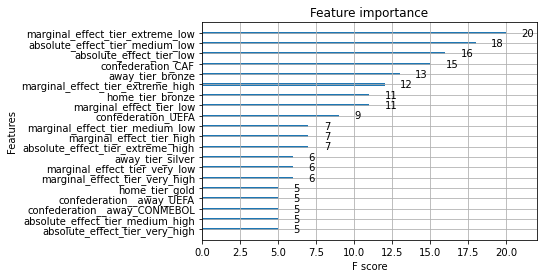

In [849]:
from xgboost import plot_importance
plot_importance(model, max_num_features=20, importance_type='weight')
plt.show()

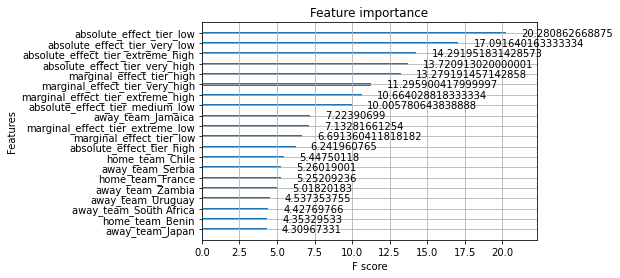

In [850]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()